In [1]:
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data=load_svmlight_file(r'F:\\机器学习实验\a9a_train.txt')
data_test=load_svmlight_file(r'F:\\机器学习实验\\a9a_test.txt')

In [3]:
y=data[1]
X=data[0]
X=X.todense()
y=np.reshape(y,(len(y),1))
y=np.mat(y)

In [4]:
X=np.hstack((X,np.ones((len(y),1))))
y_test=data_test[1]
X_test=data_test[0]
X_test=X_test.todense()
y_test=np.reshape(y_test,((len(y_test),1)))
X_test=np.hstack((X_test,np.zeros((len(y_test),1))))
X_test=np.hstack((X_test,np.ones((len(y_test),1))))

In [5]:
def hingeloss(X,w,y):
    s=0
    for i in range(0,len(w)):
        s=s+w[i]**2
    return s/2+max(0,1-y*(X*w))

hingeloss:
$$Hinge loss=\frac{||w||^2}{2}+C\sum_{i=1}^{N}max(0,1-y_i(w^TX_i+b))$$

In [8]:
def predict(X,w):#阈值为0
    y_pre=X*w
    y_pre[y_pre>=0]=1
    y_pre[y_pre<0]=-1
    return y_pre

In [6]:
def loss(X,w,y):#使用误差率作为loss
    y_predict=predict(X,w)
    n=np.zeros((len(y),1))
    n[y!=y_predict]=1
    return sum(n)/len(n)

In [7]:
def gradient(X,w,y):
    (n,m)=X.shape
    s=np.zeros((m,1))
    w[X.shape[1]-1]=0#w的最后一列是b
    for j in range(0,n):
        if(1-X[j]*w*y[j]>0):
            s=s+(X[j].T*y[j])*-1
    return s+w

梯度:
$$\frac{\partial J(w)}{\partial w}=w+C\sum_{i=1}^{N}g_w(X_i)$$

In [9]:
def NAGtrain(X,y,X_test,y_test,a,b,it,size):#it 迭代次数 size每次求梯度的部分占所有数据的比例
    (n,m)=X.shape
    w=np.zeros((m,1))
    v=np.zeros((m,1))
    time=[]
    train_err_rate=[]
    test_err_rate=[]
    for i in range(0,it):
        time.append(i+1)
        X_train, X_random, y_train, y_random = train_test_split(X, y, test_size=size, random_state=42)
        gra=gradient(X_random,w-a*v,y_random)
        v=a*v+b*gra
        w=w-v
        test_err_rate.append(loss(X_test,w,y_test))
    return w,time,test_err_rate

NAG实现原理：
$$g_t=\frac{\partial J}{\partial w}(W_{t-1}-\gamma v_{t-1})$$
$$v_t=\gamma v_{t-1}+\eta g_{t-1}$$
$$W_t=W_{t-1}-v_t$$

In [10]:
def RMStrain(X,y,X_test,y_test,a,LearningRate,it,size):
    (n,m)=X.shape
    w=np.zeros((m,1))
    g=np.zeros((m,1))
    time=[]
    train_err_rate=[]
    test_err_rate=[]
    for i in range(0,it):
        time.append(i+1)
        X_train, X_random, y_train, y_random = train_test_split(X, y, test_size=size, random_state=42)
        gra=gradient(X_random,w,y_random)
        g=a*g+(1-a)*np.multiply(gra,gra)
        w=w-np.multiply((LearningRate/np.sqrt(g+0.0000001)),gra)
        test_err_rate.append(loss(X_test,w,y_test))
    return w,time,test_err_rate

RMS
$$g_t=\frac{\partial J(W_{t-1})}{\partial w}$$
$$G_t=\gamma G_t+(1-\gamma)g_t·g_t$$

$$W_t=W_{t-1}-\frac{\eta}{\sqrt{G_t+\epsilon }}·g_t$$

In [11]:
def AdaDelta(X,y,X_test,y_test,a,it,size):
    (n,m)=X.shape
    w=np.zeros((m,1))
    g=np.zeros((m,1))
    delta=np.zeros((m,1))
    time=[]
    train_err_rate=[]
    test_err_rate=[]
    for i in range(0,it):
        time.append(i+1)
        X_train, X_random, y_train, y_random = train_test_split(X, y, test_size=size, random_state=42)
        gra=gradient(X_random,w,y_random)
        g=a*g+(1-a)*np.multiply(gra,gra)
        delta_theta=-np.multiply((np.sqrt(delta+0.0000001)/np.sqrt(g+0.0000001)),gra)
        w=w+delta_theta
        delta=a*delta+(1-a)*np.multiply(delta_theta,delta_theta)
        test_err_rate.append(loss(X_test,w,y_test))
    return w,time,test_err_rate

Adadelta
$$g_t=\Delta J(W_{t-1})$$
$$G_t=\gamma W_t+(1-\gamma)g_t·g_t$$
$$\Delta W_t=-\frac{\sqrt{\Delta _{t-1}+\epsilon}}{\sqrt{G_t+\epsilon }}·g_t$$
$$W_t=W_{t-1}+\Delta W_t$$
$$\Delta _t=\gamma \Delta _{t-1}+(1-\gamma)\Delta W_t·\Delta W_t$$

In [29]:
def Adam(X,y,X_test,y_test,b,gamma,LearningRate,it,size):
    (n,m)=X.shape
    w=np.zeros((m,1))
    g=np.zeros((m,1))
    mt=0
    time=[]
    train_err_rate=[]
    test_err_rate=[]
    for i in range(1,it+1):
        time.append(i)
        X_train, X_random, y_train, y_random = train_test_split(X, y, test_size=size, random_state=42)
        gra=gradient(X_random,w,y_random)
        mt=b*mt+(1-b)*gra
        g=gamma*g+(1-gamma)*np.multiply(gra,gra)
        a=LearningRate*(np.sqrt(1-gamma**i)/(1-b**i))
        w=w-a*mt/np.sqrt(g+0.00001)
        test_err_rate.append(loss(X_test,w,y_test))
    return w,time,test_err_rate

Adam
$$g_t=\frac{\partial J(W_{t-1})}{\partial} w$$
$$m_t=\beta _1m_{t-1}+(1-\beta)g_t$$
$$G_t=\gamma G_t+(1-\gamma)g_t·g_t$$
$$\alpha=\eta\frac{\sqrt{1-\gamma ^t}}{1-\beta ^t}$$
$$\Theta=\Theta_{t-1}-\alpha\frac{m_t}{\sqrt{G_t+\epsilon}}$$

In [18]:
theta,times,NAG_test_err=NAGtrain(X,y,X_test,y_test,0.9,0.0001,1000,0.01)

In [20]:
theta,times,RMS_test_err=RMStrain(X,y,X_test,y_test,0.9,0.001,1000,0.01)

In [34]:
theta,times,AdaDelta_test_err=AdaDelta(X,y,X_test,y_test,0.95,1000,0.01)

In [31]:
theta,times,Adam_test_err=Adam(X,y,X_test,y_test,0.9,0.99,0.01,1000,0.01)

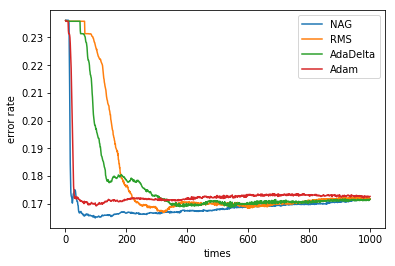

In [35]:
plt.xlabel('times')
plt.ylabel('error rate')
plt.plot(times,NAG_test_err,label="NAG")
plt.plot(times,RMS_test_err,label="RMS")
plt.plot(times,AdaDelta_test_err,label="AdaDelta")
plt.plot(times,Adam_test_err,label="Adam")
plt.legend()
plt.show()

In [36]:
NAG_test_err[-1]

array([ 0.1716725])

In [37]:
RMS_test_err[-1]

array([ 0.17161108])

In [38]:
AdaDelta_test_err[-1]

array([ 0.17154966])

In [39]:
Adam_test_err[-1]

array([ 0.17259382])